In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [3]:
from functools import partial

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

from tqdm import tqdm
tqdm.pandas()

import sys
sys.path.append('..')

from bert.dataset import encode
from bert.model import create_model
from bert.go import TreeNorm
from bert.go import Ontology

ont = Ontology()


In [4]:
swissprot_dir = '/gpfs/alpine/bie108/proj-shared/swissprot/'
swissprot = pd.read_parquet(os.path.join(swissprot_dir, 'parsed_swissprot_uniref_clusters.parquet'))
go_terms = pd.read_parquet(os.path.join(swissprot_dir, 'swissprot_quickgo.parquet'))
swissprot_annotated = swissprot[swissprot.accession.isin(go_terms['GENE PRODUCT ID'].unique())]
swissprot_annotated = swissprot_annotated[swissprot_annotated.length < 10000]

swissprot_test = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(
    np.load('/ccs/home/pstjohn/uniparc_modeling/go_annotation/uniref50_split.npz',
            allow_pickle=True)['test'])]
cafa3_test = swissprot_annotated[swissprot_annotated['accession'].isin(
    np.load('/ccs/home/pstjohn/uniparc_modeling/go_annotation/cafa3/cafa3_accessions.npz',
            allow_pickle=True)['test'])]

go_terms_swissprot_test = go_terms[go_terms['GENE PRODUCT ID'].isin(swissprot_test.accession)]
go_terms_cafa3_test = go_terms[go_terms['GENE PRODUCT ID'].isin(cafa3_test.accession)]

grouped_go_terms_swissprot = go_terms_swissprot_test.groupby('GENE PRODUCT ID')['GO TERM'].apply(lambda x: x.values)
grouped_go_terms_cafa3 = go_terms_cafa3_test.groupby('GENE PRODUCT ID')['GO TERM'].apply(lambda x: x.values)

swissprot_test_true = grouped_go_terms_swissprot.reindex(swissprot_test.accession).progress_apply(
    lambda x: ont.termlist_to_array(ont.get_ancestors(x)))

cafa3_test_true = grouped_go_terms_cafa3.reindex(cafa3_test.accession).progress_apply(
    lambda x: ont.termlist_to_array(ont.get_ancestors(x)))

y_true_swissprot = np.vstack(swissprot_test_true.values)
y_true_cafa3 = np.vstack(cafa3_test_true.values)

100%|██████████| 3140/3140 [00:04<00:00, 737.63it/s]


In [5]:
import pickle

with open('/ccs/home/pstjohn/member_work/20201018_test_set.p', 'rb') as f:
    data = pickle.load(f)

In [6]:
list(data.keys())

['20201008_go_finetuning.397941',
 '20201008_go_finetuning_noinit.399528',
 '20201008_go_finetuning_cafa3_shuffle3.415744',
 '20201008_go_finetuning_cafa3_noinit.410235']

In [7]:
data['20201008_go_finetuning.397941']['cafa']['metrics']

[0.0050619298761541195, 0.5589632, 0.75524205, 0.6887269]

In [8]:
swissprot_test = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(np.load('uniref50_split.npz', allow_pickle=True)['test'])]
cafa3_test = swissprot_annotated[swissprot_annotated['accession'].isin(np.load('cafa3/cafa3_accessions.npz', allow_pickle=True)['test'])]

In [9]:
def flat_fmax():
    for model in data.keys():
        for dataset in ['cafa', 'swissprot']:
            metrics = data[model][dataset]['metrics']
            for target, fmax in zip(['BP', 'MF', 'CC'], metrics[1:]):               
                yield (model, dataset, target, fmax)
                
fmax = pd.DataFrame(flat_fmax(), columns=['model', 'data_target', 'ont_target', 'fmax'])
fmax['preinit'] = ~fmax.model.str.contains('noinit')
fmax['train_data'] = fmax.model.str.contains('cafa3')
fmax['train_data'] = fmax['train_data'].replace({True: 'cafa3', False: 'swissprot'})
fmax = fmax.sort_values(by=['ont_target', 'train_data', 'preinit'])
fmax.head()

,model,data_target,ont_target,fmax,preinit,train_data
18,20201008_go_finetuning_cafa3_noinit.410235,cafa,BP,0.354326,False,cafa3
21,20201008_go_finetuning_cafa3_noinit.410235,swissprot,BP,0.416401,False,cafa3
12,20201008_go_finetuning_cafa3_shuffle3.415744,cafa,BP,0.766130,True,cafa3
15,20201008_go_finetuning_cafa3_shuffle3.415744,swissprot,BP,0.745123,True,cafa3
6,20201008_go_finetuning_noinit.399528,cafa,BP,0.383428,False,swissprot


In [50]:
offset_preinit = .2
offset_dataset = .45

fmax['x'] = fmax.ont_target.replace({'BP': 0, 'CC': 1, 'MF': 2})
fmax['x'] += fmax['preinit'] * offset_preinit
fmax['x'] += (fmax['train_data'] == 'cafa3') * offset_dataset

In [51]:
fmax_cafa = fmax[fmax.data_target == 'cafa'].copy()
fmax_swissprot = fmax[fmax.data_target == 'swissprot'].copy()

In [193]:
fmax[fmax.data_target == 'cafa'].groupby('ont_target').max()

,model,data_target,fmax,preinit,train_data,x
ont_target,,,,,,
BP,20201008_go_finetuning_noinit.399528,cafa,0.766130,True,swissprot,0.65
CC,20201008_go_finetuning_noinit.399528,cafa,0.804875,True,swissprot,1.65
MF,20201008_go_finetuning_noinit.399528,cafa,0.848005,True,swissprot,2.65


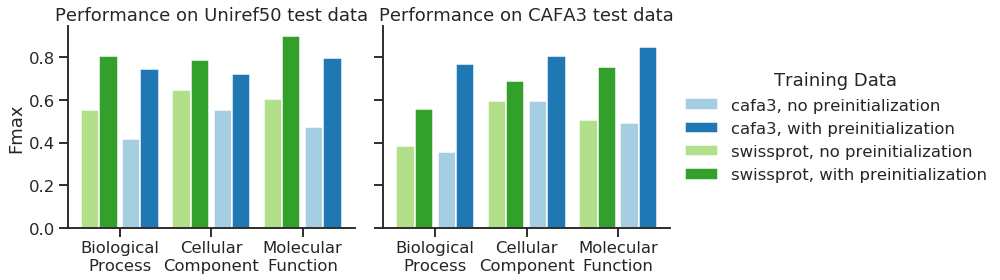

In [167]:
fig, (ax1, ax) = plt.subplots(figsize=(14,4), ncols=2, sharey=True)
for (labels, df), color in zip(fmax[fmax.data_target == 'swissprot'].groupby(['train_data', 'preinit']), sns.color_palette("Paired")):
    ax1.bar(df.x, height=df.fmax, width=0.2, color=color, label=f"{labels[0]}, {'with' if labels[1] else 'no'} preinitialization", align='edge')
    
ax1.set_xticks(np.arange(3) + .85/2)
ax1.set_xticklabels(['Biological\nProcess', 'Cellular\nComponent', 'Molecular\nFunction'])
ax1.set_ylabel('Fmax')
ax1.set_title('Performance on Uniref50 test data')

# ax.bar(x=fmax_cafa.x, height=fmax_cafa.fmax, width=0.2, color=[:4] * 4)
for (labels, df), color in zip(fmax[fmax.data_target == 'cafa'].groupby(['train_data', 'preinit']), sns.color_palette("Paired")):
    ax.bar(df.x, height=df.fmax, width=0.2, color=color, label=f"{labels[0]}, {'with' if labels[1] else 'no'} preinitialization", align='edge')
    
ax.legend(loc='center left', bbox_to_anchor=(1., .5), title='Training Data')
ax.set_xticks(np.arange(3) + .85/2)
ax.set_xticklabels(['Biological\nProcess', 'Cellular\nComponent', 'Molecular\nFunction'])
#ax.set_ylabel('Fmax')
ax.set_title('Performance on CAFA3 test data')
sns.despine()

plt.tight_layout()

plt.savefig('figures/fmax.pdf')

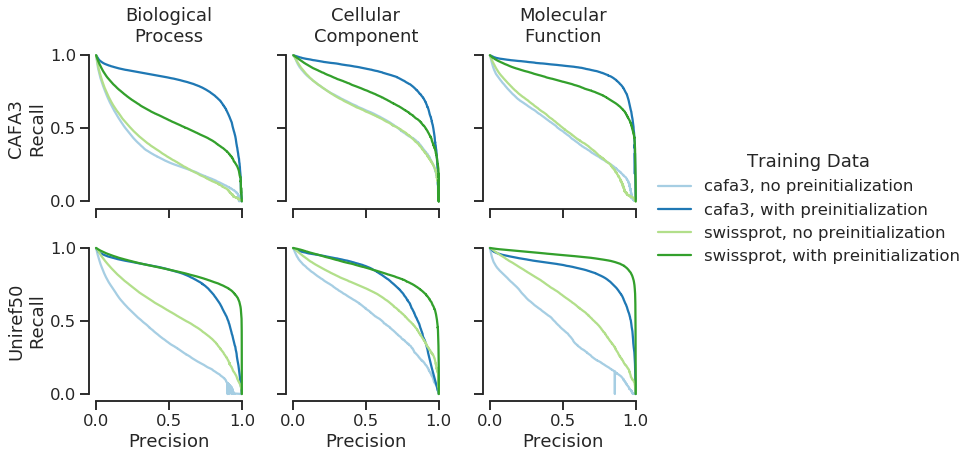

In [176]:
models = [('20201008_go_finetuning_cafa3_noinit.410235', 'cafa3, no preinitialization'),
          ('20201008_go_finetuning_cafa3_shuffle3.415744', 'cafa3, with preinitialization'),
          ('20201008_go_finetuning_noinit.399528', 'swissprot, no preinitialization'),
          ('20201008_go_finetuning.397941', 'swissprot, with preinitialization')]

fig, axmatrix = plt.subplots(nrows=2, ncols=3, figsize=(10, 6.5), sharex=True, sharey=True)

for ax in axmatrix.flatten():
    ax.set_aspect('equal')
    
    
def plot_sorted(x, y, ax, **kwargs):
    idx = x.argsort()
    ax.plot(x[idx], y[idx], **kwargs)
    

for (model, label), color in zip(models, sns.color_palette("Paired")):
    for dataset, axs in zip(['cafa', 'swissprot'], axmatrix):
        plot_sorted(data[model][dataset]['precision_bp'], data[model][dataset]['recall_bp'], axs[0], color=color)
        plot_sorted(data[model][dataset]['precision_cc'], data[model][dataset]['recall_cc'], axs[1], color=color)
        plot_sorted(data[model][dataset]['precision_mf'], data[model][dataset]['recall_mf'], axs[2], color=color, label=label)


axmatrix[0, 0].set_ylabel('CAFA3\nRecall')
axmatrix[1, 0].set_ylabel('Uniref50\nRecall')
for ax in axmatrix[1,:]:
    ax.set_xlabel('Precision')
    
axmatrix[0,0].set_title('Biological\nProcess')
axmatrix[0,1].set_title('Cellular\nComponent')
axmatrix[0,2].set_title('Molecular\nFunction')
        
leg = axmatrix[0, 2].legend(loc='center left', bbox_to_anchor=(1., .0), title='Training Data')

sns.despine(trim=True)
# plt.tight_layout()
plt.savefig('figures/pr_curves.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')

In [188]:
model = '20201008_go_finetuning.397941'
dataset = 'swissprot'
thresholds = []

for cat in ['bp', 'cc', 'mf']:
    
    fmax_idx = ((2 * data[model][dataset][f'precision_{cat}'] * data[model][dataset][f'recall_{cat}']) / 
                (data[model][dataset][f'precision_{cat}'] + data[model][dataset][f'recall_{cat}'])).argmax()

    thresholds += [data[model][dataset][f'thresholds_{cat}'][fmax_idx]]

In [190]:
np.array(thresholds).mean()

0.4458

masked language pretraining has a huge effect. Need to look into why the cafa3 training data is better for the cafa3 targets. Is there an overlap of terms or similarity?

In [114]:
import os
swissprot_dir = '/gpfs/alpine/bie108/proj-shared/swissprot/'

swissprot = pd.read_parquet(os.path.join(swissprot_dir, 'parsed_swissprot_uniref_clusters.parquet'))
go_terms = pd.read_parquet(os.path.join(swissprot_dir, 'swissprot_quickgo.parquet'))

swissprot_split = np.load('uniref50_split.npz', allow_pickle=True)
cafa3_accessions = np.load('cafa3/cafa3_accessions.npz', allow_pickle=True)

In [119]:
cafa3_accessions['test']

array(['P48349', 'O04375', 'O04376', ..., 'P0A153', 'P59479', 'P0A171'],
      dtype=object)

In [121]:
swissprot_train = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(swissprot_split['train'])]
swissprot_test = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(swissprot_split['test'])]
cafa3_train = swissprot_annotated[swissprot_annotated['accession'].isin(cafa3_accessions['train'])]
cafa3_test = swissprot_annotated[swissprot_annotated['accession'].isin(cafa3_accessions['test'])]

In [129]:
len(cafa3_train['UniRef50 ID'][cafa3_train['UniRef50 ID'].isin(cafa3_test['UniRef50 ID'])].unique())

1991

In [144]:
!pip install matplotlib-venn

     |################################| 40 kB 1.3 MB/s eta 0:00:011
  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.5-py3-none-any.whl size=32394 sha256=6dc29d20bcfbf9c439bde62fd00f2e4c57cd9357ad2b45c380415e84e6c543b9
  Stored in directory: /autofs/nccs-svm1_home1/pstjohn/.cache/pip/wheels/9d/6e/6c/9338bc6bbd01bc676b2e30371a5a931385649c7ed8c503a9b6
Successfully built matplotlib-venn


In [153]:
from venn import venn

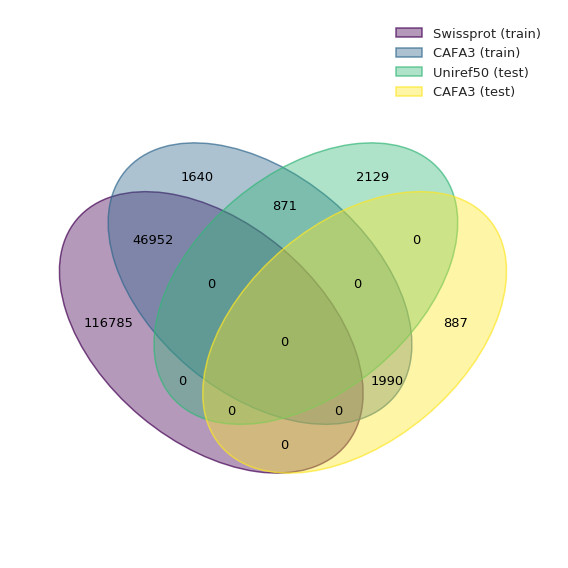

In [177]:
venn({
    'Swissprot (train)': set(swissprot_train['UniRef50 ID'].dropna().unique()),
    'CAFA3 (train)': set(cafa3_train['UniRef50 ID'].dropna().unique()),
    'Uniref50 (test)': set(swissprot_test['UniRef50 ID'].dropna().unique()),
    'CAFA3 (test)': set(cafa3_test['UniRef50 ID'].dropna().unique()),
})

plt.tight_layout()
plt.savefig('figures/venn.pdf')